In [6]:
import random

import numpy as np
import torch
import torch.nn as nn
%matplotlib inline
import matplotlib.pyplot as plt


from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy import select

#from network.models import MashVAE
from network.convert_recipe import build_grain_type_lookup_maps, convert_recipe_numpy, NUM_GRAIN_SLOTS
from db_scripts.brewbrain_db import BREWBRAIN_DB_ENGINE_STR, Base, Grain, RecipeML

TRAINING_SET_PCT = 0.75
TESTING_SET_PCT  = 1.0 - TRAINING_SET_PCT

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [94]:
engine = create_engine(BREWBRAIN_DB_ENGINE_STR, echo=False, future=True)
Base.metadata.create_all(engine)

# Build a map of recipes converted to a form that's easy to turn into tensors / feed to our network
converted_recipes = {}
with Session(engine) as session:
  grains_db = session.scalars(select(Grain)).all()
  grains_dbid_to_idx, grains_idx_to_dbid = build_grain_type_lookup_maps(grains_db)
  # Split into training, validation, test sets
  recipes_db = session.scalars(select(RecipeML)).all()
  converted_recipes = convert_recipe_numpy(recipes_db, grains_dbid_to_idx)
  random.shuffle(converted_recipes)

  training_size = int(TRAINING_SET_PCT*len(converted_recipes))
  training_recipes = converted_recipes[:training_size]
  test_recipes     = converted_recipes[training_size:]

In [140]:
def layer_init_ortho(layer, std=np.sqrt(2)):
  nn.init.orthogonal_(layer.weight, std)
  nn.init.constant_(layer.bias, 0.0)
  return layer

def layer_init_xavier(layer, nonlinearity='relu', param=0):
  nn.init.xavier_normal_(layer.weight, nn.init.calculate_gain(nonlinearity, param))
  nn.init.constant_(layer.bias, 0.0)
  return layer

LEAKY_RELU_SLOPE = 0.1
HIDDEN_SIZE = 64
Z_SIZE = 8
enc1 = layer_init_xavier(nn.Linear(NUM_GRAIN_SLOTS, HIDDEN_SIZE), 'leaky_relu', LEAKY_RELU_SLOPE)
enc2 = layer_init_xavier(nn.Linear(HIDDEN_SIZE, 2*Z_SIZE), 'linear')
dec1 = layer_init_xavier(nn.Linear(Z_SIZE, HIDDEN_SIZE), 'leaky_relu', LEAKY_RELU_SLOPE)
dec2 = layer_init_xavier(nn.Linear(HIDDEN_SIZE, NUM_GRAIN_SLOTS), 'tanh')

GAMMA = 1000.0
MAX_CAPACITY = 25
C_STOP_ITER = 1e5
C_max = torch.Tensor([MAX_CAPACITY])
num_iter = 0

def loss_fn(x, x_hat, mean, logvar, num_iter):
  recons_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
  kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean ** 2 - logvar.exp(), dim=1), dim=0)
  C = torch.clamp(C_max/C_STOP_ITER * num_iter, 0, C_max.data[0])
  loss = recons_loss + GAMMA * (kl_loss - C).abs() #n_kl_beta * kl_loss
  return loss

def reparameterize(mu, logvar):
  std = torch.exp(0.5 * logvar)
  eps = torch.randn_like(std)
  return eps * std + mu

optim_params = list(enc1.parameters()) + list(enc2.parameters()) + list(dec1.parameters()) + list(dec2.parameters()) + list(C_max)
optimizer = torch.optim.Adam(optim_params, lr=1e-2, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5000, eps=1e-6)

27884
Loss: 9.21388053894043, lr: 6.25e-05, C: 25.0
Loss: 12.929237365722656, lr: 6.25e-05, C: 25.0
Loss: 8.765822410583496, lr: 6.25e-05, C: 25.0
Loss: 5.5884881019592285, lr: 6.25e-05, C: 25.0
Loss: 9.12101936340332, lr: 6.25e-05, C: 25.0
Loss: 3.409226179122925, lr: 6.25e-05, C: 25.0
Loss: 12.268985748291016, lr: 6.25e-05, C: 25.0
Loss: 9.945664405822754, lr: 6.25e-05, C: 25.0
Loss: 4.984566688537598, lr: 6.25e-05, C: 25.0
Loss: 14.12186050415039, lr: 6.25e-05, C: 25.0
Loss: 4.076439380645752, lr: 6.25e-05, C: 25.0
Loss: 10.90313720703125, lr: 6.25e-05, C: 25.0
Loss: 7.206167221069336, lr: 6.25e-05, C: 25.0
Loss: 3.134222984313965, lr: 6.25e-05, C: 25.0
Loss: 2.893266439437866, lr: 6.25e-05, C: 25.0
Loss: 5.520336627960205, lr: 6.25e-05, C: 25.0
Loss: 3.8446261882781982, lr: 6.25e-05, C: 25.0
Loss: 6.498044490814209, lr: 6.25e-05, C: 25.0
Loss: 7.197047233581543, lr: 6.25e-05, C: 25.0
Loss: 9.157845497131348, lr: 6.25e-05, C: 25.0
Loss: 2.8210437297821045, lr: 6.25e-05, C: 25.0
Loss

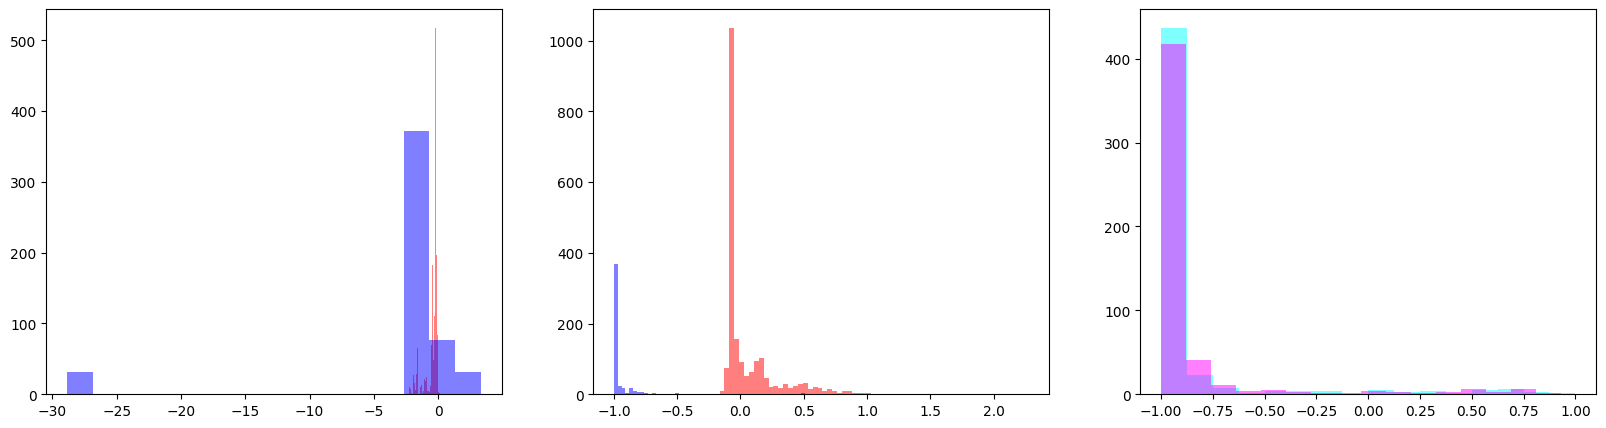

In [164]:
NUM_EPOCHS = 10
BATCH_SIZE = 32

plt.close()
fig, (ax1, ax2, axInOut) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

test_batch_loader = torch.utils.data.DataLoader(training_recipes, batch_size=BATCH_SIZE)

print(len(training_recipes))
#optimizer.param_groups[0]['lr'] = 1e-3
def forward(x, plot=False):
    x = nn.functional.leaky_relu(enc1(x), LEAKY_RELU_SLOPE)
    if plot: ax1.hist(x.flatten().detach().numpy(), bins=HIDDEN_SIZE, facecolor='red', alpha=0.5)
    x = enc2(x)
    if plot: ax1.hist(x.flatten().detach().numpy(), bins=2*Z_SIZE, facecolor='blue', alpha=0.5)

    mean, logvar = torch.chunk(x, 2, dim=-1)
    z = reparameterize(mean, logvar)

    x_hat = nn.functional.leaky_relu(dec1(z), LEAKY_RELU_SLOPE)
    if plot: ax2.hist(x_hat.flatten().detach().numpy(), bins=HIDDEN_SIZE, facecolor='red', alpha=0.5)
    x_hat = torch.tanh(dec2(x_hat))
    if plot: ax2.hist(x_hat.flatten().detach().numpy(), bins=HIDDEN_SIZE, facecolor='blue', alpha=0.5)
    return x_hat, mean, logvar

for i in range(NUM_EPOCHS):
  for batch_idx, batch_data in enumerate(test_batch_loader):
    show_graphs = i == 0 and batch_idx == BATCH_SIZE-1 
    x = (batch_data['amts'] - 0.5) * 2.0 # Normalize to [0,1]
    x_hat, mean, logvar = forward(x, show_graphs)
    if show_graphs:
      #idx = random.randint(0,BATCH_SIZE-1)
      axInOut.hist(x.flatten().detach().numpy(), bins=NUM_GRAIN_SLOTS, facecolor='cyan', alpha=0.5)
      axInOut.hist(x_hat.flatten().detach().numpy(), bins=NUM_GRAIN_SLOTS, facecolor='magenta', alpha=0.5)

    num_iter += 1
    loss = loss_fn(x, x_hat, mean, logvar, num_iter)
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    if batch_idx % 100 == 0: print(f"Loss: {loss.item()}, lr: {optimizer.param_groups[0]['lr']}, C: {torch.clamp(C_max/C_STOP_ITER * num_iter, 0, C_max.data[0]).item()}")

print(f"Loss: {loss.item()}")
plt.show()


tensor([0.7000, 0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.6860, 0.1730, 0.0780, 0.0320, 0.0130, 0.0050, 0.0010, 0.0010, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.7840, 0.1180, 0.0780, 0.0200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.7690, 0.1010, 0.0680, 0.0250, 0.0100, 0.0060, 0.0020, 0.0010, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.7000, 0.1700, 0.1300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.7000, 0.1600, 0.0710, 0.0360, 0.0150, 0.0050, 0.0010, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.4880, 0.3170, 0.1950, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

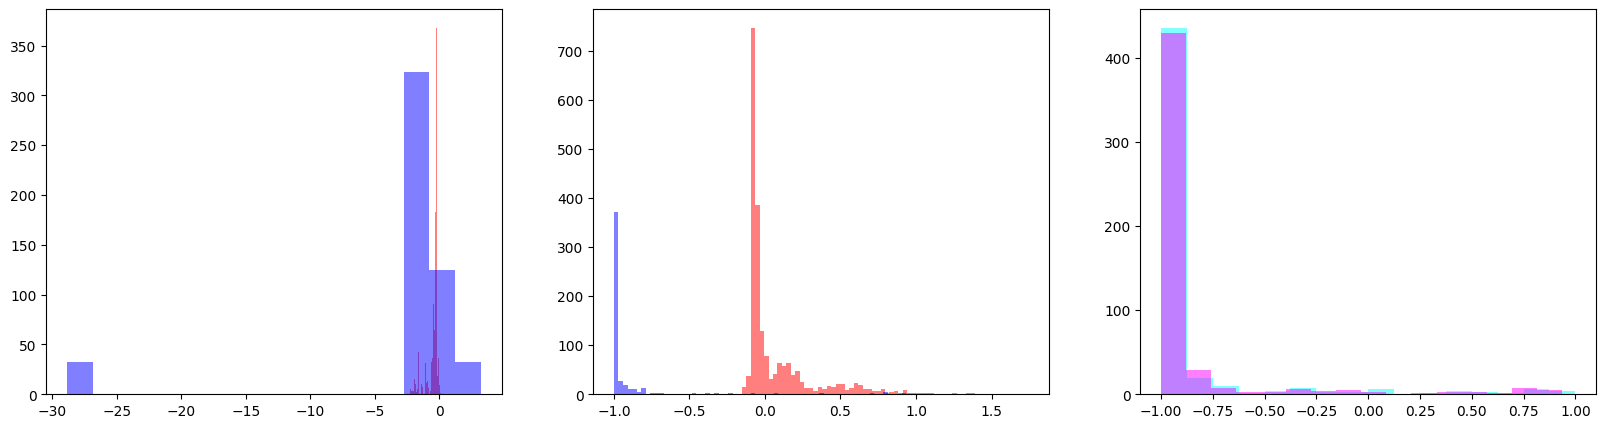

In [165]:
plt.close()
fig, (ax1, ax2, axInOut) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

data = next(iter(test_batch_loader))
with torch.no_grad():
  x = (data['amts'] - 0.5) * 2.0
  x_hat, mean, logvar = forward(x, True)
  
  axInOut.hist(x.flatten().detach().numpy(), bins=NUM_GRAIN_SLOTS, facecolor='cyan', alpha=0.5)
  axInOut.hist(x_hat.flatten().detach().numpy(), bins=NUM_GRAIN_SLOTS, facecolor='magenta', alpha=0.5)

  for i in range(x.shape[0]):
    print(torch.round(x[i]/2.0 + 0.5, decimals=3))
    print(torch.round(x_hat[i]/2.0 + 0.5, decimals=3))


In [156]:

class MashVAE(nn.Module):
  def __init__(self, num_grain_types, num_grain_slots, hidden_size, z_size) -> None:
    super().__init__()
    GRAIN_EMBED_SIZE = 128

    self.num_grain_slots = num_grain_slots
    self.num_grain_types = num_grain_types

    self.grain_type_embed = nn.Embedding(num_grain_types, GRAIN_EMBED_SIZE)
    self.input_size = (GRAIN_EMBED_SIZE + 1) * num_grain_slots # type embed (embed size floats) + percentage of the mass (1 float)
    self.encoder = nn.Sequential(
      layer_init_ortho(nn.Linear(self.input_size, hidden_size)),
      nn.LeakyReLU(inplace=True),
      layer_init_ortho(nn.Linear(hidden_size, 2*z_size))
    )
    self.decoder = nn.Sequential(
      layer_init_ortho(nn.Linear(z_size, hidden_size)),
      nn.LeakyReLU(inplace=True),
      layer_init_ortho(nn.Linear(hidden_size, self.input_size)),
    )
    self.type_decoder = layer_init_ortho(nn.Linear(GRAIN_EMBED_SIZE, num_grain_types))

    #LOGVAR_INIT = 0.0
    #self.logvar = nn.Parameter(torch.ones(size=()) * LOGVAR_INIT)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling as if coming from the input space
    return sample

  def encode(self, x):
    h = self.encoder(x)
    mu, logvar = torch.chunk(h, 2, dim=-1)
    return mu, logvar

  def decode(self, z):
    x_hat = self.decoder(z)
    type_x_hats, amt_x_hats = torch.split(x_hat, (self.num_grain_slots * self.grain_type_embed.embedding_dim, self.num_grain_slots), dim=-1)

    category_x_hats = self.type_decoder(type_x_hats.view(z.shape[0],self.num_grain_slots,-1))
    amt_x_hats = torch.sigmoid(amt_x_hats.view(z.shape[0],self.num_grain_slots,-1))

    return category_x_hats, amt_x_hats

  def forward(self, batch_mashes, sample_posterior=True):
    # batch_mashes is a tuple (type_indices, amount_percentages), shape is ((B, num_grain_slots), (B, num_grain_slots))
    embed_types = self.grain_type_embed(batch_mashes[0]).view(batch_mashes[0].shape[0], -1)
    x = torch.cat([embed_types, batch_mashes[1]], dim=-1)
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar) if sample_posterior else mu

    category_reconst, amount_reconst = self.decode(z)
    return category_reconst, amount_reconst, (mu, logvar)

  def loss(self, batch_mashes, category_reconsts, amount_reconsts, posteriors, kl_weight=0.1):
    # batch_mashes is the original input to the network, 
    # it's a tuple (type_indices, amount_percentages), shape is ((B, num_grain_slots), (B, num_grain_slots))
    
    # Break the reconstructions up to get the types and amounts
    #one_hot_cats = nn.functional.one_hot(batch_mashes[0].long(), self.num_grain_types).float()
    #cat_reconst_loss = nn.functional.binary_cross_entropy_with_logits(category_reconsts, one_hot_cats, reduction='sum')
    #cat_reconst_loss /= category_reconsts.shape[0]
    cat_reconst_loss = torch.zeros((1,))

    amt_reconst_loss = nn.functional.mse_loss(amount_reconsts, batch_mashes[1].unsqueeze(-1), reduction='sum')

    mu, logvar = posteriors
    kl_loss = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())

    total_loss = cat_reconst_loss + amt_reconst_loss + kl_weight * kl_loss

    return total_loss, amt_reconst_loss, cat_reconst_loss, kl_loss


'''
class DiagonalGaussianDistribution(object):
  def __init__(self, parameters):
    self.parameters = parameters
    self.mean, self.logvar = torch.chunk(parameters, 2, dim=-1)
    self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
    self.std = torch.exp(0.5 * self.logvar)
    self.var = torch.exp(self.logvar)

  def sample(self):
    x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
    return x

  def kl(self, other=None):
    if other is None:
      return 0.5 * torch.sum(torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar, dim=-1)
    else:
      return 0.5 * torch.sum(torch.pow(self.mean - other.mean, 2) / other.var + self.var / other.var - 1.0 - self.logvar + other.logvar, dim=-1)

  def nll(self, sample):
    LOG_TWO_PI = np.log(2.0 * np.pi)
    return 0.5 * torch.sum(LOG_TWO_PI + self.logvar + torch.pow(sample - self.mean, 2) / self.var, dim=-1)

  def mode(self): return self.mean


class MashVAE(nn.Module):
  def __init__(self, num_grain_types, num_grain_slots, hidden_size, z_size) -> None:
    super().__init__()
    GRAIN_EMBED_SIZE = 128

    self.num_grain_slots = num_grain_slots
    self.num_grain_types = num_grain_types

    self.grain_type_embed = nn.Embedding(num_grain_types, GRAIN_EMBED_SIZE)
    self.input_size = (GRAIN_EMBED_SIZE + 1) * num_grain_slots # type embed (embed size floats) + percentage of the mass (1 float)
    self.encoder = nn.Sequential(
      layer_init_ortho(nn.Linear(self.input_size, hidden_size)),
      nn.ReLU(inplace=True),
      layer_init_ortho(nn.Linear(hidden_size, 2*z_size))
    )
    self.decoder = nn.Sequential(
      layer_init_ortho(nn.Linear(z_size, hidden_size)),
      nn.ReLU(inplace=True),
      layer_init_ortho(nn.Linear(hidden_size, self.input_size)),
    )
    self.type_decoder = layer_init_ortho(nn.Linear(GRAIN_EMBED_SIZE, num_grain_types))

    #LOGVAR_INIT = 0.0
    #self.logvar = nn.Parameter(torch.ones(size=()) * LOGVAR_INIT)

  def encode(self, x):
    h = self.encoder(x)
    posterior = DiagonalGaussianDistribution(h)
    return posterior

  def decode(self, z):
    x_hat = self.decoder(z)
    type_x_hats, amt_x_hats = torch.split(x_hat, (self.num_grain_slots * self.grain_type_embed.embedding_dim, self.num_grain_slots), dim=-1)

    category_x_hats = self.type_decoder(type_x_hats.view(z.shape[0],self.num_grain_slots,-1))
    amt_x_hats = amt_x_hats.view(z.shape[0],self.num_grain_slots,-1)

    return category_x_hats, amt_x_hats

  def forward(self, batch_mashes, sample_posterior=True):
    # batch_mashes is a tuple (type_indices, amount_percentages), shape is ((B, num_grain_slots), (B, num_grain_slots))
    embed_types = self.grain_type_embed(batch_mashes[0]).view(batch_mashes[0].shape[0], -1)
    x = torch.cat([embed_types, batch_mashes[1]], dim=-1)
    posterior = self.encode(x)
    z = posterior.sample() if sample_posterior else posterior.mode()
    category_reconst, amount_reconst = self.decode(z)
    return category_reconst, amount_reconst, posterior

  def loss(self, batch_mashes, category_reconsts, amount_reconsts, posteriors, kl_weight=0.1):
    # batch_mashes is the original input to the network, 
    # it's a tuple (type_indices, amount_percentages), shape is ((B, num_grain_slots), (B, num_grain_slots))
    
    # Break the reconstructions up to get the types and amounts
    #one_hot_cats = nn.functional.one_hot(batch_mashes[0].long(), self.num_grain_types).float()
    #cat_reconst_loss = nn.functional.binary_cross_entropy_with_logits(category_reconsts, one_hot_cats, reduction='sum')
    #cat_reconst_loss /= category_reconsts.shape[0]
    cat_reconst_loss = torch.zeros((1,))

    amt_reconst_loss = nn.functional.mse_loss(amount_reconsts, batch_mashes[1].unsqueeze(-1), reduction='sum')
    amt_reconst_loss /= amount_reconsts.shape[0]
    #amt_reconst_loss = torch.abs(amount_reconsts - batch_mashes[1].unsqueeze(-1))
    #nll_loss = amt_reconst_loss / torch.exp(self.logvar) + self.logvar
    #amt_reconst_loss = torch.sum(nll_loss) / nll_loss.shape[0]

    # Calculate the KL loss
    kl_loss = posteriors.kl()
    kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

    total_loss = cat_reconst_loss + amt_reconst_loss + kl_weight * kl_loss

    return total_loss, amt_reconst_loss, cat_reconst_loss, kl_loss
'''

num_grain_types = len(grains_idx_to_dbid)
mash_vae = MashVAE(num_grain_types, NUM_GRAIN_SLOTS, 512, 1024)
optim_params = list(mash_vae.parameters())# + list(loss_fn.parameters())
optimizer = torch.optim.Adam(optim_params)

def build_batch_tensors_tuple(samples):
  batch_grain_types = []
  batch_grain_amts  = []
  for recipe_mash in samples:
    batch_grain_types.append(torch.tensor(recipe_mash['type_inds'], dtype=torch.long))
    batch_grain_amts.append(torch.tensor(recipe_mash['amts'], dtype=torch.float))
  return (torch.stack(batch_grain_types), torch.stack(batch_grain_amts))

In [ ]:
# Training
NUM_EPOCHS = 100
BATCH_SIZE = 128

optimizer.param_groups[0]['lr'] = 1e-5 # Learning Rate

batch_loader = torch.utils.data.DataLoader(training_recipes, batch_size=BATCH_SIZE)

mash_vae.train()
for epoch in range(NUM_EPOCHS):
  print(f"Epoch {epoch+1}...")
  for batch_idx, batch_samples in enumerate(batch_loader):

    #rndInds = np.random.choice(range(len(training_recipes)), (BATCH_SIZE), replace=False)
    #batch_mashes = build_batch_tensors_tuple(training_recipes, rndInds)
    batch_mashes = (batch_samples['type_inds'], batch_samples['amts'])
    
    category_reconsts, amount_reconsts, posteriors = mash_vae(batch_mashes)
    total_loss, amt_reconst_loss, cat_reconst_loss, kl_loss = mash_vae.loss(batch_mashes, category_reconsts, amount_reconsts, posteriors, kl_weight=0.6)

    optimizer.zero_grad()
    total_loss.backward()
    nn.utils.clip_grad_norm_(optim_params, 0.5)
    optimizer.step()

    if batch_idx % 10 == 0:
      print(f"[Batch: {batch_idx+1}]: loss={total_loss.item()}, grain amounts loss={amt_reconst_loss.item()}, grain types loss={cat_reconst_loss.item()}, kl_loss={kl_loss.item()}")

  optimizer.param_groups[0]['lr'] /= 2.0
print("Training finished.")

In [ ]:
TEST_BATCH_SIZE   = 32

test_batch_loader = torch.utils.data.DataLoader(training_recipes, batch_size=TEST_BATCH_SIZE)
mash_vae.eval()
with torch.no_grad():
  # See how the network fairs against the training set
  for batch_idx, batch_samples in enumerate(test_batch_loader):
    
    test_batch_mashes = (batch_samples['type_inds'], batch_samples['amts'])
   
    category_reconsts, amount_reconsts, posteriors = mash_vae(test_batch_mashes, sample_posterior=True)
    total_loss, amt_reconst_loss, cat_reconst_loss, kl_loss = mash_vae.loss(test_batch_mashes, category_reconsts, amount_reconsts, posteriors)
    print(f"[{batch_idx+1}]: loss={total_loss.item()}, grain amounts loss={amt_reconst_loss.item()}, grain types loss={cat_reconst_loss.item()}, kl_loss={kl_loss.item()}")

    # What does a malt bill look like - original vs. decoded...
    CHECK_IDX = 0
    type_inds = test_batch_mashes[0][CHECK_IDX].cpu().numpy()
    amts = test_batch_mashes[1][CHECK_IDX].cpu().numpy()

    #print(f"Original - Types: {type_inds}, Amounts: {amts}")
    print(f"Original  - Amounts: {amts.round(3)}")

    type_inds = nn.functional.softmax(category_reconsts[CHECK_IDX], dim=0)
    type_inds = torch.argmax(type_inds, dim=1, keepdim=True).flatten()

    #decoded = {'type_inds': type_inds.cpu().numpy(), 'amts': nn.functional.softmax(amount_reconsts[0], dim=0).flatten().cpu().numpy()}
    #print(f"Decoded  - Types: {decoded['type_inds'].astype(np.int32).tolist()}, Amounts: {decoded['amts'].tolist()}")
    print(f"Decoded  - Amounts: {amount_reconsts[0].flatten().cpu().numpy().round(3)}")


